# SEP Pitch-angle distribution (PAD) and first-order anisotropies

This tool visualizes SEP pitch-angle distributions based on sectored measuremetns, and determines the first-order anisotropy of the SEP PAD including different methods. 

The tool includes pre-event background subtraction, for which the selected background interval is fitted (using potentially time-dependent models) and extrapolated into the future.

In [ ]:
from anisotropy import run_SEPevent, select_sc_inst
import datetime as dt
import numpy as np
import os
import pandas as pd

### Select a local folder to save the downloaded data

In [ ]:
path = f"{os.getcwd()}{os.sep}data"

### Select Spacecraft & Instrument, particle species, and energy channel

In [ ]:
spacecraft_instrument = select_sc_inst()

RadioButtons(description='Spacecraft & instrument:', layout=Layout(width='max-content'), options=('Solar Orbit…

In [ ]:
species = "e"
channels = 3  
averaging = "2min"  # time averaging

Information on available energy channels for the selected instrument are shown in the output below. Run it once with an arbitrary selection to get the information, then update the selection here, and run it again.

# Set data loading and plotting window

Spacecraft: Solar Orbiter
Instrument: EPT. Species: e. Channels: 3.

Available energy channels:
                      energy
channel                     
0        0.0312 - 0.0354 MeV
1        0.0334 - 0.0374 MeV
2        0.0356 - 0.0396 MeV
3        0.0382 - 0.0420 MeV
4        0.0408 - 0.0439 MeV
5        0.0439 - 0.0467 MeV
6        0.0467 - 0.0505 MeV
7        0.0505 - 0.0542 MeV
8        0.0542 - 0.0588 MeV
9        0.0588 - 0.0635 MeV
10       0.0635 - 0.0682 MeV
11       0.0682 - 0.0739 MeV
12       0.0739 - 0.0798 MeV
13       0.0798 - 0.0866 MeV
14       0.0866 - 0.0942 MeV
15       0.0942 - 0.1021 MeV
16       0.1021 - 0.1107 MeV
17       0.1107 - 0.1207 MeV
18       0.1207 - 0.1314 MeV
19       0.1314 - 0.1432 MeV
20       0.1432 - 0.1552 MeV
21       0.1552 - 0.1690 MeV
22       0.1690 - 0.1849 MeV
23       0.1849 - 0.2004 MeV
24       0.2004 - 0.2182 MeV
25       0.2182 - 0.2379 MeV
26       0.2379 - 0.2590 MeV
27       0.2590 - 0.2826 MeV
28       0.2826 - 0.3067 MeV
29   

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

solo_l2_mag-srf-normal_20211101_v01.cdf:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

solo_l2_mag-srf-normal_20211102_v01.cdf:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Loading MAG...


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

solo_l2_mag-rtn-normal_20211031_v02.cdf:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

solo_l2_mag-rtn-normal_20211101_v01.cdf:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

solo_l2_mag-rtn-normal_20211102_v01.cdf:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

RED = INWARD, negative polarity, [90, 270] degrees
BLUE = OUTWARD, positive polarity, [270, 360] and [0, 90] degrees
Calculating PA coverage for EPT...


  0%|          | 0/780 [00:00<?, ?it/s]

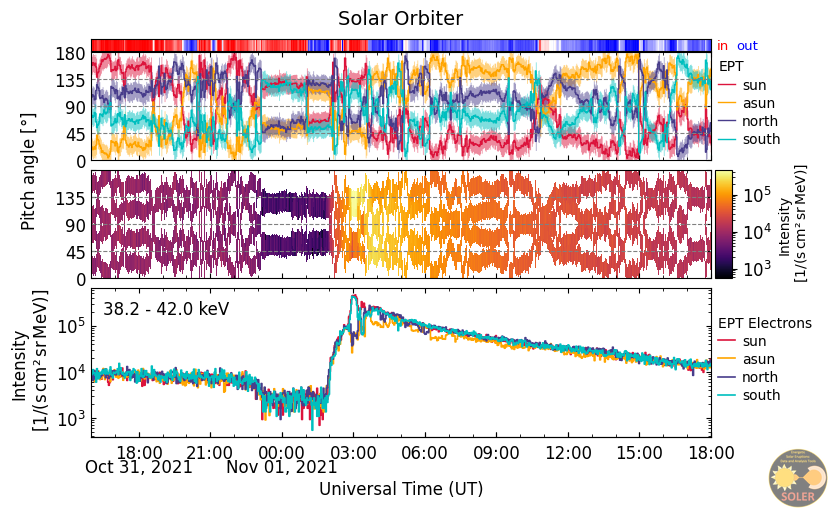

In [ ]:
start_time = pd.to_datetime('2021-10-31 16:00:00')
end_time = pd.to_datetime('2021-11-01 18:00:00')

event = run_SEPevent(path, spacecraft_instrument.value, start_time, end_time, species=species, channels=channels, averaging=averaging)
fig, axes = event.overview_plot()

# Background analysis and subtraction
#### Choose a background window!
To determine the (potentially time-dependent) intensity background we fit both, a constant and an exponentially decaying model to the sector-averaged background intensity. We chose the better fit based on the reduded chi-squares. Then the model is extrapolated in time and subtracted from the measured intensities.

In [ ]:
# chose a background window. Setting these to None will set default window [start_time, start_time + 5 hours] 
bg_start = pd.to_datetime('2021-10-31 23:00:00')  # None
bg_end =  pd.to_datetime('2021-11-01 01:30:00')  # None

# chose an end time for the background subtraction:
# if None then background subraction stops 3 hours after the end of the background window (bg_end)
corr_window_end = None  # pd.to_datetime('2021-11-01 18:00:00') 

# resets background window and event.corr_window_end which is used to check that the background is not above the observations near the event start
event.set_background_window(bg_start, bg_end, corr_window_end)

# averaging (in minutes) used for the background analysis
bg_av_min = 10  

event.background_analysis_all(minutes=bg_av_min)
fig, axes = event.overview_plot_bgsub()

Background window start: 2021-10-31 23:00:00
Background window end: 2021-11-01 01:30:00
Background correction window end: 2021-11-01 04:30:00
Reduced chi-squared (constant model): 1.51
Reduced chi-squared (exponential model): 1.49


# Determine Anisotropies

Anisotropies are determined with and without background subtraction. 

### Choose the method for anisotropy calculation: 
- weighted-sum method (strongly suggested if only 4 viewing directions are available). The weighted-sum method is described in Brüdern et al. 2018, Central European Astrophysical Bulletin, 42, 2.

  
- weighted-sum method including bootstrapping: provides uncertainties for the anisotropy based on bootstrapping within intensity uncertainty ranges

- fit method: pitch-angle distributions are fitted with 2nd-order Legendre Polionomials to determine the anisotropy


Note that anisotropies during noisy low-intensity intervals (like right before the SEP event) cannot be trusted.

In [ ]:
ani_method = 'weighted_sum_bootstrap'  # 'weighted_sum', 'weighted_sum_bootstrap', or 'fit'; 
                                       #'weighted_sum_bootstrap' not available for Wind!

event.calculate_anisotropy(ani_method=ani_method)
fig, axes = event.anisotropy_plot(ani_method=ani_method)

### Plot explanations: 

#### Anisotropy panel:

First order anisotropies without (black) and with (magenta) background subtraction. 
Gray and magenta shades around the anisotropy lines show the anisotropy uncertainty based 2.5 and 95 percentiles resulting from the bootstrapping analysis based on counting rate statistics (and the background subtraction - magenta trace) (only shown when `ani_method='weighted_sum_bootstrap'`).

Gray shades at the top and bottom of the panel show anisotropy values that cannot be determined with the instrument's pitch-angle coverage at that time.

----------------------
#### Plarity bar at the top of the plot marks the magnetic field polarity:

RED = INWARD, negative polarity, [90, 270] degrees

BLUE = OUTWARD, positive polarity, [270, 360] and [0, 90] degrees